In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4); seed = 1; torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
import warnings
from sklearn.decomposition import PCA
from textwrap import wrap
from scipy.stats import wilcoxon
from scipy.linalg import subspace_angles

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from model_working import *
from functions import *
# os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Generate data for subspace angles

In [5]:
start = time.time()

all_data = {}

d = 'pr'    # number of dimensions for each subspace
# d = 2

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
    
        if hp_test['dend_nonlinearity'] not in ['subtractive', 'divisive_2']:
            print('filtered')
            continue
            
        # load data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()

        # group trials
        trial_labels = label_trials_wcst(test_data=test_data)
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        rule1_trs_after_error = trial_labels['rule1_trs_after_error']
        rule2_trs_after_error = trial_labels['rule2_trs_after_error']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
#         resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
#         error_trials = trial_labels['error_trials']
        stable_trs = rule1_trs_stable + rule2_trs_stable
#         stims = [_[0] for _ in test_data['stims']]
#         ref_cards = [_['center_card'] for _ in stims]
#         ref00trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==0 and ref_cards[tr]['shape']==0]
#         ref01trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==0 and ref_cards[tr]['shape']==1]
#         ref10trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==1 and ref_cards[tr]['shape']==0]
#         ref11trs = [tr for tr in range(len(ref_cards)) if ref_cards[tr]['color']==1 and ref_cards[tr]['shape']==1]
        
        
        
#         # do PCA over all trajectories
# #         time_period = np.arange(hp_task_test['trial_start']//hp_test['dt'], hp_task_test['trial_end']//hp_test['dt'])     # entire trial
#         time_period = np.arange(hp_task_test['trial_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])    # fdbk + ITI
# #         time_period = np.arange(hp_task_test['center_card_on']//hp_test['dt'], hp_task_test['test_cards_on']//hp_test['dt'])    # ref card only
# #         time_period = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])    # ref card + test cards (response)
#         neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
#         rnn_activity_used = rnn_activity[:, :, :, neuron_used][:, time_period, :, :]   # part of activity used for PCA
#         rnn_activity_used = rnn_activity_used[:, :, 0, :]    # squeeze the batch dimension
#         print(rnn_activity_used.shape)
#         pca_all_traj = PCA(n_components=10)
#         rnn_activity_flat = rnn_activity_used.reshape(rnn_activity_used.shape[0]*rnn_activity_used.shape[1], rnn_activity_used.shape[-1])
#         pca_all_traj.fit(rnn_activity_flat)
#         print('pca of all trajs', pca_all_traj.explained_variance_ratio_)
        
        
        # obtain different subspaces
        # generate subspaces
        neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
        time_used_rule = np.arange(hp_task_test['trial_history_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])    # use the inter-trial epoch
#         time_used_rule = np.arange(hp_task_test['center_card_on']//hp_test['dt'], hp_task_test['test_cards_off']//hp_test['dt'])    # use the task epoch
        time_used_choice = np.arange(hp_task_test['resp_start']//hp_test['dt'], hp_task_test['resp_end']//hp_test['dt'])
        
        ## rule 1 subspace
        rnn_activity_sm_rule1 = rnn_activity[rule1_trs_stable, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
        rnn_activity_sm_rule1_flat = rnn_activity_sm_rule1.reshape(rnn_activity_sm_rule1.shape[0]*rnn_activity_sm_rule1.shape[1], rnn_activity_sm_rule1.shape[-1])
        subspace_rule1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_flat, d=d)
        print('exp var ratio of rule 1 subspace:', exp_var_ratio)
        
        ## rule 2 subspace
        rnn_activity_sm_rule2 = rnn_activity[rule2_trs_stable, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
        rnn_activity_sm_rule2_flat = rnn_activity_sm_rule2.reshape(rnn_activity_sm_rule2.shape[0]*rnn_activity_sm_rule2.shape[1], rnn_activity_sm_rule2.shape[-1])
        subspace_rule2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_flat, d=d)
        print('exp var ratio of rule 2 subspace:', exp_var_ratio)
        
        ## choice 1 subspace
        rnn_activity_sm_c1 = rnn_activity[c1_trs_stable, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_sm_c1_flat = rnn_activity_sm_c1.reshape(rnn_activity_sm_c1.shape[0]*rnn_activity_sm_c1.shape[1], rnn_activity_sm_c1.shape[-1])
        subspace_c1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c1_flat, d=d)
        print('exp var ratio of choice 1 subspace:', exp_var_ratio)
        
        ## choice 2 subspace
        rnn_activity_sm_c2 = rnn_activity[c2_trs_stable, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_sm_c2_flat = rnn_activity_sm_c2.reshape(rnn_activity_sm_c2.shape[0]*rnn_activity_sm_c2.shape[1], rnn_activity_sm_c2.shape[-1])
        subspace_c2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c2_flat, d=d)
        print('exp var ratio of choice 2 subspace:', exp_var_ratio)
        
        ## choice 3 subspace
        rnn_activity_sm_c3 = rnn_activity[c3_trs_stable, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_sm_c3_flat = rnn_activity_sm_c3.reshape(rnn_activity_sm_c3.shape[0]*rnn_activity_sm_c3.shape[1], rnn_activity_sm_c3.shape[-1])
        subspace_c3, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c3_flat, d=d)
        print('exp var ratio of choice 3 subspace:', exp_var_ratio)
        
        # rule subspace
        rnn_activity_rule = rnn_activity[stable_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
        rnn_activity_rule_flat = rnn_activity_rule.reshape(rnn_activity_rule.shape[0]*rnn_activity_rule.shape[1], rnn_activity_rule.shape[-1])
        subspace_rule, exp_var_ratio, n_dim = compute_subspace(rnn_activity_rule_flat, d=d)
#         print('exp var ratio of rule subspace:', exp_var_ratio)
        
        # choice subspace
        rnn_activity_choice = rnn_activity[stable_trs, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
        rnn_activity_choice_flat = rnn_activity_choice.reshape(rnn_activity_choice.shape[0]*rnn_activity_choice.shape[1], rnn_activity_choice.shape[-1])
        subspace_choice, exp_var_ratio, n_dim = compute_subspace(rnn_activity_choice_flat, d=d)
#         print('exp var ratio of choice subspace:', exp_var_ratio)
        
        # compute angle between subspaces
        angle_rule_subspace = np.rad2deg(subspace_angles(subspace_rule1.T, subspace_rule2.T)[0])
        angle_choice12_subspace = np.rad2deg(subspace_angles(subspace_c1.T, subspace_c2.T)[0])
        angle_choice13_subspace = np.rad2deg(subspace_angles(subspace_c1.T, subspace_c3.T)[0])
        angle_choice23_subspace = np.rad2deg(subspace_angles(subspace_c2.T, subspace_c3.T)[0])
        angle_choice_subspace_avg = np.mean([angle_choice12_subspace, angle_choice13_subspace, angle_choice23_subspace])
        angle_rule_choice = np.rad2deg(subspace_angles(subspace_rule.T, subspace_choice.T)[0])
        
        
        # Do the same for shuffled data
        angle_rules_shuffle = []
        angle_choices_shuffle = []
        angle_rule_choices_shuffle = []
        
        for _ in range(100):
            # split trials within each rule and choice
            rule1_trs_split1 = np.random.choice(rule1_trs_stable, size=len(rule1_trs_stable)//2, replace=False)
            rule1_trs_split2 = [tr for tr in rule1_trs_stable if tr not in rule1_trs_split1]
            rule2_trs_split1 = np.random.choice(rule2_trs_stable, size=len(rule2_trs_stable)//2, replace=False)
            rule2_trs_split2 = [tr for tr in rule2_trs_stable if tr not in rule2_trs_split1]
            
            c1_trs_split1 = np.random.choice(c1_trs_stable, size=len(c1_trs_stable)//2, replace=False)
            c1_trs_split2 = [tr for tr in c1_trs_stable if tr not in c1_trs_split1]
            c2_trs_split1 = np.random.choice(c2_trs_stable, size=len(c2_trs_stable)//2, replace=False)
            c2_trs_split2 = [tr for tr in c2_trs_stable if tr not in c2_trs_split1]
            c3_trs_split1 = np.random.choice(c3_trs_stable, size=len(c3_trs_stable)//2, replace=False)
            c3_trs_split2 = [tr for tr in c3_trs_stable if tr not in c3_trs_split1]

            # generate subspaces
            ## rule 1 subspace
            ### split trials within each rule
            rnn_activity_sm_rule1_split1 = rnn_activity[rule1_trs_split1, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule1_split1 = rnn_activity_sm_rule1_split1.reshape(rnn_activity_sm_rule1_split1.shape[0]*rnn_activity_sm_rule1_split1.shape[1], rnn_activity_sm_rule1_split1.shape[-1])
            subspace_rule1_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_split1, d=d)
            if _==0:
                print('exp var ratio of rule 1 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_rule1_split2 = rnn_activity[rule1_trs_split2, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule1_split2 = rnn_activity_sm_rule1_split2.reshape(rnn_activity_sm_rule1_split2.shape[0]*rnn_activity_sm_rule1_split2.shape[1], rnn_activity_sm_rule1_split2.shape[-1])
            subspace_rule1_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_split2, d=d)
            if _==0:
                print('exp var ratio of rule 1 subspace (split2):', exp_var_ratio)
            
            

            ## rule 2 subspace
            ### split trials within each rule
            rnn_activity_sm_rule2_split1 = rnn_activity[rule2_trs_split1, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule2_split1 = rnn_activity_sm_rule2_split1.reshape(rnn_activity_sm_rule2_split1.shape[0]*rnn_activity_sm_rule2_split1.shape[1], rnn_activity_sm_rule2_split1.shape[-1])
            subspace_rule2_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_split1, d=d)
            if _==0:
                print('exp var ratio of rule 2 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_rule2_split2 = rnn_activity[rule2_trs_split2, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_sm_rule2_split2 = rnn_activity_sm_rule2_split2.reshape(rnn_activity_sm_rule2_split2.shape[0]*rnn_activity_sm_rule2_split2.shape[1], rnn_activity_sm_rule2_split2.shape[-1])
            subspace_rule2_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_split2, d=d)
            if _==0:
                print('exp var ratio of rule 2 subspace (split2):', exp_var_ratio)

                
                
            ## choice 1 subspace
            ### another way, split trials within each choice
            rnn_activity_sm_c1_split1 = rnn_activity[c1_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c1_split1 = rnn_activity_sm_c1_split1.reshape(rnn_activity_sm_c1_split1.shape[0]*rnn_activity_sm_c1_split1.shape[1], rnn_activity_sm_c1_split1.shape[-1])
            subspace_c1_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c1_split1, d=d)
            if _==0:
                print('exp var ratio of choice 1 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_c1_split2 = rnn_activity[c1_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c1_split2 = rnn_activity_sm_c1_split2.reshape(rnn_activity_sm_c1_split2.shape[0]*rnn_activity_sm_c1_split2.shape[1], rnn_activity_sm_c1_split2.shape[-1])
            subspace_c1_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c1_split2, d=d)
            if _==0:
                print('exp var ratio of choice 1 subspace (split2):', exp_var_ratio)
                
            ## choice 2 subspace
            ### split trials within each choice
            rnn_activity_sm_c2_split1 = rnn_activity[c2_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c2_split1 = rnn_activity_sm_c2_split1.reshape(rnn_activity_sm_c2_split1.shape[0]*rnn_activity_sm_c2_split1.shape[1], rnn_activity_sm_c2_split1.shape[-1])
            subspace_c2_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c2_split1, d=d)
            if _==0:
                print('exp var ratio of choice 2 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_c2_split2 = rnn_activity[c2_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c2_split2 = rnn_activity_sm_c2_split2.reshape(rnn_activity_sm_c2_split2.shape[0]*rnn_activity_sm_c2_split2.shape[1], rnn_activity_sm_c2_split2.shape[-1])
            subspace_c2_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c2_split2, d=d)
            if _==0:
                print('exp var ratio of choice 2 subspace (split2):', exp_var_ratio)

                
            ## choice 3 subspace
            ###  split trials within each choice
            rnn_activity_sm_c3_split1 = rnn_activity[c3_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c3_split1 = rnn_activity_sm_c3_split1.reshape(rnn_activity_sm_c3_split1.shape[0]*rnn_activity_sm_c3_split1.shape[1], rnn_activity_sm_c3_split1.shape[-1])
            subspace_c3_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c3_split1, d=d)
            if _==0:
                print('exp var ratio of choice 3 subspace (split1):', exp_var_ratio)
            rnn_activity_sm_c3_split2 = rnn_activity[c3_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_sm_c3_split2 = rnn_activity_sm_c3_split2.reshape(rnn_activity_sm_c3_split2.shape[0]*rnn_activity_sm_c3_split2.shape[1], rnn_activity_sm_c3_split2.shape[-1])
            subspace_c3_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_c3_split2, d=d)
            if _==0:
                print('exp var ratio of choice 3 subspace (split2):', exp_var_ratio)
                
                
                
                
            ## rule and choice subspaces
            rule_trs_stable = rule1_trs_stable + rule2_trs_stable
            rule_trs_split1 = np.random.choice(rule_trs_stable, size=len(rule_trs_stable)//2, replace=False)
            rule_trs_split2 = [tr for tr in rule_trs_stable if tr not in rule_trs_split1]
            
            choice_trs_stable = c1_trs_stable + c2_trs_stable + c3_trs_stable
            choice_trs_split1 = np.random.choice(choice_trs_stable, size=len(choice_trs_stable)//2, replace=False)
            choice_trs_split2 = [tr for tr in choice_trs_stable if tr not in choice_trs_split1]
            
            rnn_activity_rule_split1 = rnn_activity[rule_trs_split1, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_rule_split2 = rnn_activity[rule_trs_split2, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
            rnn_activity_rule_split1_flat = rnn_activity_rule_split1.reshape(rnn_activity_rule_split1.shape[0]*rnn_activity_rule_split1.shape[1], rnn_activity_rule_split1.shape[-1])
            rnn_activity_rule_split2_flat = rnn_activity_rule_split2.reshape(rnn_activity_rule_split2.shape[0]*rnn_activity_rule_split2.shape[1], rnn_activity_rule_split2.shape[-1])
            
            rnn_activity_choice_split1 = rnn_activity[choice_trs_split1, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_choice_split2 = rnn_activity[choice_trs_split2, :, 0, :][:, time_used_choice, :][:, :, neuron_used]
            rnn_activity_choice_split1_flat = rnn_activity_choice_split1.reshape(rnn_activity_choice_split1.shape[0]*rnn_activity_choice_split1.shape[1], rnn_activity_choice_split1.shape[-1])
            rnn_activity_choice_split2_flat = rnn_activity_choice_split2.reshape(rnn_activity_choice_split2.shape[0]*rnn_activity_choice_split2.shape[1], rnn_activity_choice_split2.shape[-1])
            
            subspace_rule_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_rule_split1_flat, d=d)
            subspace_rule_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_rule_split2_flat, d=d)
            subspace_choice_split1, exp_var_ratio, n_dim = compute_subspace(rnn_activity_choice_split1_flat, d=d)
            subspace_choice_split2, exp_var_ratio, n_dim = compute_subspace(rnn_activity_choice_split2_flat, d=d)
            
            
            # compute angle between subspaces
            angle_rule1_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule1_split1.T, subspace_rule1_split2.T)[0])
            angle_rule2_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule2_split1.T, subspace_rule2_split2.T)[0])
            angle_rule_subspace_shuffle = np.mean([angle_rule1_subspace_shuffle, angle_rule2_subspace_shuffle])
            
            angle_c1_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c1_split1.T, subspace_c1_split2.T)[0])
            angle_c2_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c2_split1.T, subspace_c2_split2.T)[0])
            angle_c3_subspace_shuffle = np.rad2deg(subspace_angles(subspace_c3_split1.T, subspace_c3_split2.T)[0])
            angle_choice_subspace_avg_shuffle = np.mean([angle_c1_subspace_shuffle, angle_c2_subspace_shuffle, angle_c3_subspace_shuffle])
            
            angle_rule_subspace_shuffle = np.rad2deg(subspace_angles(subspace_rule_split1.T, subspace_rule_split2.T )[0])
            angle_choice_subspace_shuffle = np.rad2deg(subspace_angles(subspace_choice_split1.T, subspace_choice_split2.T)[0])
            angle_rule_choice_subspace_shuffle = np.mean([angle_rule_subspace_shuffle, angle_choice_subspace_shuffle])

            # append to the list
            angle_rules_shuffle.append(angle_rule_subspace_shuffle)
            angle_choices_shuffle.append(angle_choice_subspace_avg_shuffle)
            angle_rule_choices_shuffle.append(angle_rule_choice_subspace_shuffle)

        # collect data
        all_data[model_name] = {'model_name': model_name,
                               'hp': hp_test,
                               'angle_rule_subspace': angle_rule_subspace,
                               'angle_rule_subspace_shuffle': angle_rules_shuffle,
                               'angle_choice_subspace_avg': angle_choice_subspace_avg,
                               'angle_choice_subspace_avg_shuffle': angle_choices_shuffle,
                               'angle_rule_choice': angle_rule_choice,
                               'angle_rule_choice_shuffle': angle_rule_choices_shuffle
                               }


print('Elapsed time: {} seconds'.format(time.time()-start))

# with open('/home/yl4317/Documents/two_module_rnn/processed_data/angle_subspace_intact.pickle', 'wb') as handle:
#     pickle.dump(all_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

success_2023-05-10-14-28-42_wcst_105_sparsity0
exp var ratio of rule 1 subspace: [0.8493]
exp var ratio of rule 2 subspace: [0.6738 0.2401]
exp var ratio of choice 1 subspace: [0.5475 0.2261 0.0947]
exp var ratio of choice 2 subspace: [0.4045 0.2684 0.1725 0.0544]
exp var ratio of choice 3 subspace: [0.4605 0.2499 0.1262]
exp var ratio of rule 1 subspace (split1): [0.8493]
exp var ratio of rule 1 subspace (split2): [0.8509]
exp var ratio of rule 2 subspace (split1): [0.6867 0.2383]
exp var ratio of rule 2 subspace (split2): [0.6679 0.242 ]
exp var ratio of choice 1 subspace (split1): [0.5377 0.2537 0.1076]
exp var ratio of choice 1 subspace (split2): [0.5597 0.2203 0.0994]
exp var ratio of choice 2 subspace (split1): [0.4334 0.266  0.1521]
exp var ratio of choice 2 subspace (split2): [0.3851 0.2629 0.2044 0.0533]
exp var ratio of choice 3 subspace (split1): [0.5301 0.2187 0.0992]
exp var ratio of choice 3 subspace (split2): [0.3824 0.3063 0.1661 0.0705]
success_2023-05-10-14-28-42_wcst

# Generate data for angle between subspaces when SST or PV are silenced

In [6]:
start = time.time()

with open('/home/yl4317/Documents/two_module_rnn/processed_data/angle_subspace_intact.pickle', 'rb') as handle:
    all_data_intact = pickle.load(handle)

all_data = {}

d = 'pr'

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        if model_name not in list(all_data_intact.keys()):
            print('model perf is low, excluded in previous analysis, skip')
            continue
            
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        all_data[model_name] = {'model_name': model_name, 'hp': hp_test}
        
        for cell_type in ['SST', 'PV']:
            print(cell_type)
            # subspace with inactivation
            with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_silenceSR{}_noiseless_no_current_matrix'.format(cell_type)), 'rb') as f:
                neural_data = pickle.load(f)
            test_data = neural_data['test_data']
            mean_perf = np.mean([_[0] for _ in test_data['perfs']])
            mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
            print('mean perf: {}, mean perf rule: {}'.format(mean_perf, mean_perf_rule))
            # print('perf: {}, \n perf rule: {}'.format([_[0] for _ in test_data['perfs']], [_[0] for _ in test_data['perf_rules']]))
            rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        
            if np.isnan(rnn_activity).any():
                print('NAN in rnn_activity')
                angle_rule_subspace_inact = np.nan
            else:
                # group trials
                trial_labels = label_trials_wcst(test_data=test_data)
                rule1_trs = trial_labels['rule1_trs']
                rule2_trs = trial_labels['rule2_trs']
                # c1_trs = trial_labels['c1_trs']
                # c2_trs = trial_labels['c2_trs']
                # c3_trs = trial_labels['c3_trs']
                # error_trials = trial_labels['error_trials']
    
                # generate subspaces
                neuron_used = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
                # neuron_used = list(model.rnn.cg_idx['sr_esoma'])
                time_used_rule = np.arange(hp_task_test['trial_history_start']//hp_test['dt'], hp_task_test['center_card_on']//hp_test['dt'])
                # time_used_rule = np.arange(hp_task_test['trial_history_start']//hp_test['dt'], hp_task_test['trial_end']//hp_test['dt'])
    
                ## rule 1 subspace
                rnn_activity_sm_rule1 = rnn_activity[rule1_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
                rnn_activity_sm_rule1_flat = rnn_activity_sm_rule1.reshape(rnn_activity_sm_rule1.shape[0]*rnn_activity_sm_rule1.shape[1], rnn_activity_sm_rule1.shape[-1])
                subspace_rule1_inact, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule1_flat, d=d)
                print('exp var ratio of rule 1 subspace (silence {}):'.format(cell_type), exp_var_ratio)
    
                ## rule 2 subspace
                rnn_activity_sm_rule2 = rnn_activity[rule2_trs, :, 0, :][:, time_used_rule, :][:, :, neuron_used]
                rnn_activity_sm_rule2_flat = rnn_activity_sm_rule2.reshape(rnn_activity_sm_rule2.shape[0]*rnn_activity_sm_rule2.shape[1], rnn_activity_sm_rule2.shape[-1])
                subspace_rule2_inact, exp_var_ratio, n_dim = compute_subspace(rnn_activity_sm_rule2_flat, d=d)
                print('exp var ratio of rule 2 subspace (silence {}):'.format(cell_type), exp_var_ratio)
            
                # compute angle between subspaces
                angle_rule_subspace_inact = np.rad2deg(subspace_angles(subspace_rule1_inact.T, subspace_rule2_inact.T)[0])    
        
            # collect data
            all_data[model_name]['angle_rule_subspace_no{}'.format(cell_type)] = angle_rule_subspace_inact

# with open('/home/yl4317/Documents/two_module_rnn/processed_data/angle_subspace_inactivation.pickle', 'wb') as handle:
#     pickle.dump(all_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('Elapsed time: {} seconds'.format(time.time()-start))

success_2023-05-10-14-28-42_wcst_105_sparsity0
SST
mean perf: 0.3199999928474426, mean perf rule: 0.5
exp var ratio of rule 1 subspace (silence SST): [0.64 0.31]
exp var ratio of rule 2 subspace (silence SST): [0.99]
PV
mean perf: 0.019999999552965164, mean perf rule: 0.0
NAN in rnn_activity
success_2023-05-10-14-28-42_wcst_106_sparsity0
SST
mean perf: 0.12999999523162842, mean perf rule: 0.20000000298023224
NAN in rnn_activity
PV
mean perf: 0.029999999329447746, mean perf rule: 0.05000000074505806
NAN in rnn_activity
success_2023-05-10-14-28-42_wcst_10_sparsity0
SST
mean perf: 0.3199999928474426, mean perf rule: 0.5
exp var ratio of rule 1 subspace (silence SST): [0.65 0.21]
exp var ratio of rule 2 subspace (silence SST): [0.63 0.27]
PV
mean perf: 0.4399999976158142, mean perf rule: 0.5
exp var ratio of rule 1 subspace (silence PV): [0.89]
exp var ratio of rule 2 subspace (silence PV): [0.87]
success_2023-05-10-14-28-42_wcst_112_sparsity0
model perf is low, excluded in previous analys

# Figure 6cd + supplementary figure 10ab: angle between rule and response subspaces

In [ ]:
# change this to your directory
with open('/home/yl4317/Documents/two_module_rnn/processed_data/angle_subspace_intact.pickle', 'rb') as handle:
    all_data_intact = pickle.load(handle)


model_list = list(all_data.keys())
for dend_nonlinearity in ['subtractive', 'divisive_2']:
    angle_rules_all_models = []
    angle_rules_all_models_shuffle = []
    angle_choices_all_models = []
    angle_choices_all_models_shuffle = []
    angle_rule_choice_all_models = []
    angle_rule_choice_all_models_shuffle = []
    for model in model_list:
        if all_data[model]['hp']['dend_nonlinearity'] != dend_nonlinearity:
            continue
        angle_rules_all_models.append(all_data_intact[model]['angle_rule_subspace'])
        angle_rules_all_models_shuffle.extend(all_data_intact[model]['angle_rule_subspace_shuffle'])
        angle_choices_all_models.append(all_data_intact[model]['angle_choice_subspace_avg'])
        angle_choices_all_models_shuffle.extend(all_data_intact[model]['angle_choice_subspace_avg_shuffle'])
        angle_rule_choice_all_models.append(all_data_intact[model]['angle_rule_choice'])
        angle_rule_choice_all_models_shuffle.extend(all_data_intact[model]['angle_rule_choice_shuffle'])
    
    # subspace angle compare to shuffled data
    fig, ax = plt.subplots(1, 1, figsize=[5, 3])
    bins=np.arange(0, 90, 1)
    ax.set_title('principle angle between rule subspaces\n{}'.format(dend_nonlinearity))
    ax.hist(angle_rules_all_models, color='k', density=True, bins=bins)
    ax.hist(angle_rules_all_models_shuffle, color='gray', alpha=0.5, density=True, bins=bins)
    make_pretty_axes(ax)
    ax.set_xlim([0, 90])
    ax.set_xticks([0, 90])
    fig.tight_layout()
    plt.show()
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/angle_subspace_rule_{}.pdf'.format(dend_nonlinearity))
    
    fig, ax = plt.subplots(1, 1, figsize=[5, 3])
    bins=np.arange(0, 90, 1)
    ax.set_title('principle angle between choice subspaces\n{}'.format(dend_nonlinearity))
    ax.hist(angle_choices_all_models, color='k', density=True, bins=bins)
    ax.hist(angle_choices_all_models_shuffle, color='gray', alpha=0.5, density=True, bins=bins)
    make_pretty_axes(ax)
    ax.set_xlim([0, 90])
    ax.set_xticks([0, 90])
    fig.tight_layout()
    plt.show()
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/angle_subspace_response_{}.pdf'.format(dend_nonlinearity))
            
    
    if dend_nonlinearity == 'subtractive':
        data_fig6cd = {'rule': angle_rules_all_models, 'rule_shuffle': angle_rules_all_models_shuffle, 'response': angle_choices_all_models, 'response_shuffle': angle_choices_all_models_shuffle}
    elif dend_nonlinearity == 'divisive_2':
        data_suppfig10ab = {'rule': angle_rules_all_models, 'rule_shuffle': angle_rules_all_models_shuffle, 'response': angle_choices_all_models, 'response_shuffle': angle_choices_all_models_shuffle}

# save to csv
# pd.DataFrame.from_dict(data=data_fig6cd, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig6cd.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig10ab, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig10ab.csv', header=False)

# Figure 7f and Supplementary Figure 11c: principal angle between rule subspaces when SST neurons are inhibited

In [ ]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/angle_subspace_inactivation.pickle', 'rb') as handle:
    all_data_inact = pickle.load(handle)

data_fig7f = {}
data_suppfig11c = {}

for cell_type in ['SST', 'PV']:
    for dend_nonlinear in ['subtractive', 'divisive_2']:
        print(dend_nonlinear)
    
        angles = []
        angles_inactivation = []
    
        # subspace angle when silencing SST neurons
        fig, ax = plt.subplots(1, 1, figsize=[2.75, 4])
        ax.set_title('principle angle between\n rule subspaces')
        
        model_list = list(all_data_inact.keys())
        
        for model in model_list:
            if all_data_inact[model]['hp']['dend_nonlinearity']!=dend_nonlinear:
                continue
            if ~np.isnan(all_data_inact[model]['angle_rule_subspace_no{}'.format(cell_type)]):
                ax.plot([0, 1], [all_data_intact[model]['angle_rule_subspace'], all_data_inact[model]['angle_rule_subspace_no{}'.format(cell_type)]], color='k', alpha=0.5, marker='o', clip_on=False)
                angles.append(all_data_intact[model]['angle_rule_subspace'])
                angles_inactivation.append(all_data_inact[model]['angle_rule_subspace_no{}'.format(cell_type)])
        make_pretty_axes(ax)
        ax.set_ylim([0, 90])
        ax.set_yticks([0, 90])
        ax.set_xlim([-0.2, 1.2])
        ax.set_xticks([0, 1], ['intact', 'silenced \n{}'.format(cell_type)])
        fig.tight_layout()
        plt.show()
        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/subspace_angle_silence_{}_{}.pdf'.format(cell_type, dend_nonlinear))
    
        print(scipy.stats.ttest_ind(a=angles, b=angles_inactivation, alternative='greater'))
        print('n={}'.format(len(angles)))

        if cell_type == 'SST':
            if dend_nonlinear == 'subtractive':
                data_fig7f['intact'] = angles
                data_fig7f['silence_sst'] = angles_inactivation
            elif dend_nonlinear == 'divisive_2':
                data_suppfig11c['intact'] = angles
                data_suppfig11c['silence_sst'] = angles_inactivation

# pd.DataFrame.from_dict(data=data_fig7f, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7f_subspace_angle_silenceSST_subtractive.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig11c, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig11csubspace_angle_silenceSST_divisive.csv', header=False)

In [ ]:
all_data_inact[model].keys()

# why divisive does not show decreased subspace angle?

In [ ]:
rule_sel_distribution = dict.fromkeys(itertools.product(['subtractive', 'divisive_2'], ['intact', 'nosst'], ['norm', 'unnorm']))

for key in rule_sel_distribution.keys():
    rule_sel_distribution[key] = []

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
            
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        dend_nonlinear = hp_test['dend_nonlinearity']
        
        for condition in ['intact', 'nosst']:
            print(condition)
            if condition == 'intact':
                file_appendix = '_testdata_noiseless_no_current_matrix'
            elif condition == 'nosst':
                file_appendix = '_testdata_silenceSRSST_noiseless_no_current_matrix_2'
            with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+file_appendix), 'rb') as f:
                neural_data = pickle.load(f)
            test_data = neural_data['test_data']
            mean_perf = np.mean([_[0] for _ in test_data['perfs']])
            print('mean_perf = {}'.format(mean_perf))
            if condition == 'intact' and mean_perf < 0.8:
                print('low perf model, pass')
                break
            mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
            rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
            trial_labels = label_trials_wcst(test_data=test_data)
            if condition == 'intact':
                rule1_trs = trial_labels['rule1_trs_stable']
                rule2_trs = trial_labels['rule2_trs_stable']
            elif condition == 'nosst':
                rule1_trs = trial_labels['rule1_trs']
                rule2_trs = trial_labels['rule2_trs']
            rule1_activity_avg = np.mean(rnn_activity[rule1_trs, :, 0, :], axis=(0, 1))
            rule2_activity_avg = np.mean(rnn_activity[rule2_trs, :, 0, :], axis=(0, 1))
            rule_sels_norm = (rule1_activity_avg - rule2_activity_avg) / (rule1_activity_avg + rule2_activity_avg)
            rule_sels = (rule1_activity_avg - rule2_activity_avg)
            neuron_idx = list(model.rnn.cg_idx['sr_esoma']) + list(model.rnn.cg_idx['sr_pv']) + list(model.rnn.cg_idx['sr_sst']) + list(model.rnn.cg_idx['sr_vip'])
            rule_sels_norm = rule_sels_norm[neuron_idx]
            rule_sels = rule_sels[neuron_idx]

            rule_sel_distribution[dend_nonlinear, condition, 'norm'].extend(rule_sels_norm)
            rule_sel_distribution[dend_nonlinear, condition, 'unnorm'].extend(rule_sels)

In [ ]:
for dend_nonlinear in ['subtractive', 'divisive_2']:
    for rule_sel_type in ['norm', 'unnorm']:
        fig, ax = plt.subplots(1, 1, figsize=[7, 3])
        fig.suptitle(dend_nonlinear + ',' + rule_sel_type)
        ax.hist(rule_sel_distribution[dend_nonlinear, 'intact', rule_sel_type], label='intact', alpha=0.5, bins=20)
        ax.hist(rule_sel_distribution[dend_nonlinear, 'nosst', rule_sel_type], label='nosst', alpha=0.5, bins=20)
        ax.legend()
        make_pretty_axes(ax)
        plt.show()
        # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/rule_sel_distrib_{}_{}.pdf'.format(dend_nonlinear, rule_sel_type))
        

# Maybe divisive nonlinearity networks have smaller current from SST to dendrite?

In [ ]:
current_sst_to_edends = {'subtractive': [], 'divisive_2': []}
current_pfc_to_edends = {'subtractive': [], 'divisive_2': []}
input_weight_to_edends = {'subtractive': [], 'divisive_2': []}

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        dend_nonlinear = hp_test['dend_nonlinearity']
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        print('mean_perf = {}'.format(mean_perf))
        if mean_perf < 0.8:
            print('low perf model, pass')
            continue
            
        rnn_activity = neural_data['rnn_activity'][:, :, 0, :].detach().numpy()
        # for cg in model.rnn.cell_group_list:
        #     test = rnn_activity[:, :, model.rnn.cg_idx[cg]]
        #     print(cg, np.min(test), np.max(test))
        w_rec = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask, w_fix=model.rnn.w_fix).detach().numpy()
        w_in = model.rnn.effective_weight(w=model.rnn.w_in, mask=model.rnn.mask_in).detach().numpy()
        current_sst_to_edend = rnn_activity[:, :, model.rnn.cg_idx['sr_sst']] @ w_rec[np.ix_(model.rnn.cg_idx['sr_sst'], model.rnn.cg_idx['sr_edend'])]
        current_sst_to_edend = np.mean(current_sst_to_edend, axis=(0, 1))    # average over time and trial
        current_sst_to_edends[dend_nonlinear].extend(current_sst_to_edend)
        current_pfc_to_edend = rnn_activity[:, :, model.rnn.cg_idx['pfc_esoma']] @ w_rec[np.ix_(model.rnn.cg_idx['pfc_esoma'], model.rnn.cg_idx['sr_edend'])]
        current_pfc_to_edend = np.mean(current_pfc_to_edend, axis=(0, 1))    # average over time and trial
        current_pfc_to_edends[dend_nonlinear].extend(current_pfc_to_edend)
        input_weight_to_edend = w_in[:, model.rnn.cg_idx['sr_edend']]
        input_weight_to_edend = np.mean(input_weight_to_edend, axis=0)
        input_weight_to_edends[dend_nonlinear].extend(input_weight_to_edend)

ratio = {}    # ratio between the PFC->edend excitation and SST->edend inhibition
for dend_nonlinear in ['subtractive', 'divisive_2']:
    ratio[dend_nonlinear] = current_pfc_to_edends[dend_nonlinear] / np.abs(current_sst_to_edends[dend_nonlinear])
    ratio[dend_nonlinear] = [_ for _ in ratio[dend_nonlinear] if _<=10]
    print(np.min(ratio[dend_nonlinear]), np.max(ratio[dend_nonlinear]), np.mean(ratio[dend_nonlinear]))

In [ ]:
for source in ['pfc_esoma', 'sr_sst', 'ratio', 'input']:
    if source == 'sr_sst':
        data_to_plot = current_sst_to_edends
    elif source == 'pfc_esoma':
        data_to_plot = current_pfc_to_edends
    elif source == 'ratio':
        data_to_plot = ratio
    elif source == 'input':
        data_to_plot = input_weight_to_edends
    fig, ax = plt.subplots()
    for dend_nonlinear in ['subtractive', 'divisive_2']:
        print(dend_nonlinear)
        ax.hist(data_to_plot[dend_nonlinear], alpha=0.5, label=dend_nonlinear, bins=100)
    ax.set_title(source)
    ax.set_ylabel('# dendritic branches', fontsize=20)
    ax.legend(prop={'size':12})
    # if source == 'ratio':
    #     ax.set_xlim([0, 10])
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/current_to_sredend_{}.pdf'.format(source))

# Why inhibiting PV also reduce subspace angle? Look at top-down input to PV vs. SST

In [9]:
top_down_weight = {'to_sr_sst': [], 'to_sr_pv': []}

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        dend_nonlinear = hp_test['dend_nonlinearity']
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        print('mean_perf = {}'.format(mean_perf))
        if mean_perf < 0.8:
            print('low perf model, pass')
            continue
        # rnn_activity = neural_data['rnn_activity'][:, :, 0, :].detach().numpy()
        # for cg in model.rnn.cell_group_list:
        #     test = rnn_activity[:, :, model.rnn.cg_idx[cg]]
        #     print(cg, np.min(test), np.max(test))
        w_rec = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask, w_fix=model.rnn.w_fix).detach().numpy()
        # w_in = model.rnn.effective_weight(w=model.rnn.w_in, mask=model.rnn.mask_in).detach().numpy()
        for target in ['sr_sst', 'sr_pv']:
            weight = w_rec[np.ix_(model.rnn.cg_idx['pfc_esoma'], model.rnn.cg_idx[target])]
            weight = np.mean(weight, axis=1)    # average over targets (look at the mean weight from each PFC E cell to all the SR SST/PV cells)
            top_down_weight['to_{}'.format(target)].extend(weight)


success_2023-05-10-14-28-42_wcst_105_sparsity0
mean_perf = 0.887499988079071
success_2023-05-10-14-28-42_wcst_106_sparsity0
mean_perf = 0.887499988079071
success_2023-05-10-14-28-42_wcst_10_sparsity0
mean_perf = 0.8999999761581421
success_2023-05-10-14-28-42_wcst_112_sparsity0
mean_perf = 0.0
low perf model, pass
success_2023-05-10-14-28-42_wcst_115_sparsity0
mean_perf = 0.125
low perf model, pass
success_2023-05-10-14-28-42_wcst_116_sparsity0
mean_perf = 0.925000011920929
success_2023-05-10-14-28-42_wcst_118_sparsity0
mean_perf = 0.887499988079071
success_2023-05-10-14-28-42_wcst_121_sparsity0
mean_perf = 0.8999999761581421
success_2023-05-10-14-28-42_wcst_122_sparsity0
mean_perf = 0.887499988079071
success_2023-05-10-14-28-42_wcst_124_sparsity0
mean_perf = 0.875
success_2023-05-10-14-28-42_wcst_126_sparsity0
mean_perf = 0.9375
success_2023-05-10-14-28-42_wcst_131_sparsity0
mean_perf = 0.887499988079071
success_2023-05-10-14-28-42_wcst_134_sparsity0
mean_perf = 0.887499988079071
succe

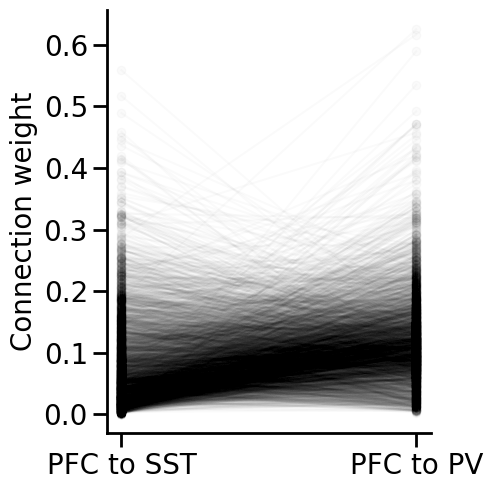

Ttest_indResult(statistic=-24.48309667931307, pvalue=1.4078657709010578e-127)


In [24]:
# plotting 
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot([top_down_weight['to_sr_sst'], top_down_weight['to_sr_pv']], color='k', marker='o', alpha=0.02)
ax.set_xticks([0, 1])
ax.set_xticklabels(['PFC to SST', 'PFC to PV'])
ax.set_ylabel('Connection weight', fontsize=20)
make_pretty_axes(ax)
fig.tight_layout()
plt.show()
fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/top_down_to_pv_sst.pdf')

ttest = scipy.stats.ttest_ind(a=top_down_weight['to_sr_sst'], b=top_down_weight['to_sr_pv'], alternative='less')
print(ttest)

In [14]:
scipy.stats.ttest_ind(a=np.arange(100, 200), b=np.arange(0, 100), alternative='greater')

Ttest_indResult(statistic=24.373333911071626, pvalue=8.065072679854722e-62)